In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape
from darts.datasets import EnergyDataset
from darts import concatenate

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging
logging.disable(logging.CRITICAL)

In [4]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [5]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(12, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "MAPE: {}".format(mape(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

,Monthly Anamoly
DateTime,
1880-01-01,-0.139
1880-02-01,3.050
1880-03-01,6.034
1880-04-01,9.972
1880-05-01,15.601


Text(0.5, 1.0, 'Tokyo Temp')

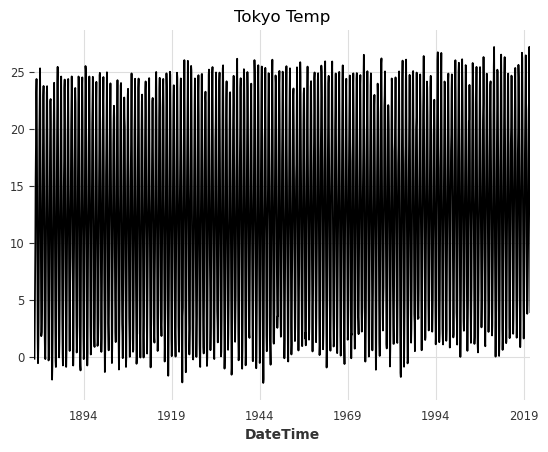

In [6]:
rawdata = pd.read_csv("../data/all_cities_month_temp_df.csv")
rawdata = rawdata.loc[rawdata.loc[:,"city_num"] == 2]
rawdata["DateTime"] = rawdata["year"].astype('str') + '-' + rawdata["month"].astype('str')
rawdata = rawdata.loc[:,["DateTime", "Monthly Anamoly"]]
rawdata["DateTime"] = pd.to_datetime(rawdata["DateTime"])
rawdata = rawdata.loc[rawdata['DateTime'] >= '1880-01-01']
rawdata.set_index("DateTime", inplace=True, drop=True)
display(rawdata.head())

rawdata["Monthly Anamoly"].plot()
plt.title("Tokyo Temp")

In [7]:
series = TimeSeries.from_dataframe(rawdata).astype(np.float32)
scaler = Scaler()
train = series
# train, val = series.split_after(pd.Timestamp("20141201"))

Text(0.5, 1.0, 'Tokyo Temp')

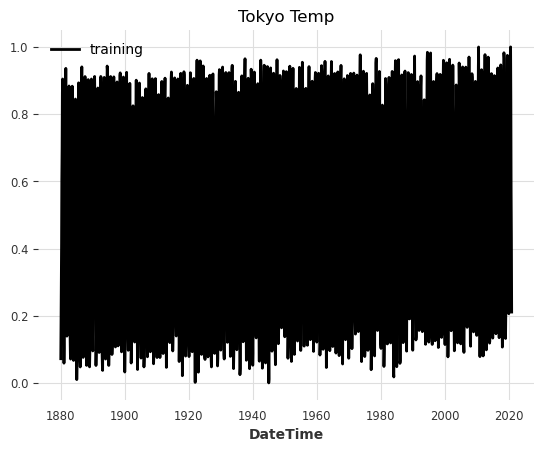

In [8]:
train_scaled = scaler.fit_transform(train)
# val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

train_scaled.plot(label="training")
# val_scaled.plot(label="val")
plt.title("Tokyo Temp")

In [9]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=480,
    output_chunk_length=60,
    generic_architecture=False,
    num_blocks=7,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=64,
    random_state=156,
    model_name=model_name,
    # save_checkpoints=True,
    # force_reset=True,
    **generate_torch_kwargs(),
)

In [10]:
model_nbeats.fit(train_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=7, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=480, output_chunk_length=60, n_epochs=100, nr_epochs_val_period=1, batch_size=64, random_state=156, model_name=nbeats_run, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x177d63f40>]})

In [11]:
#model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [12]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=pd.Timestamp('2005-01-01'),
    forecast_horizon=60,
    stride=1,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

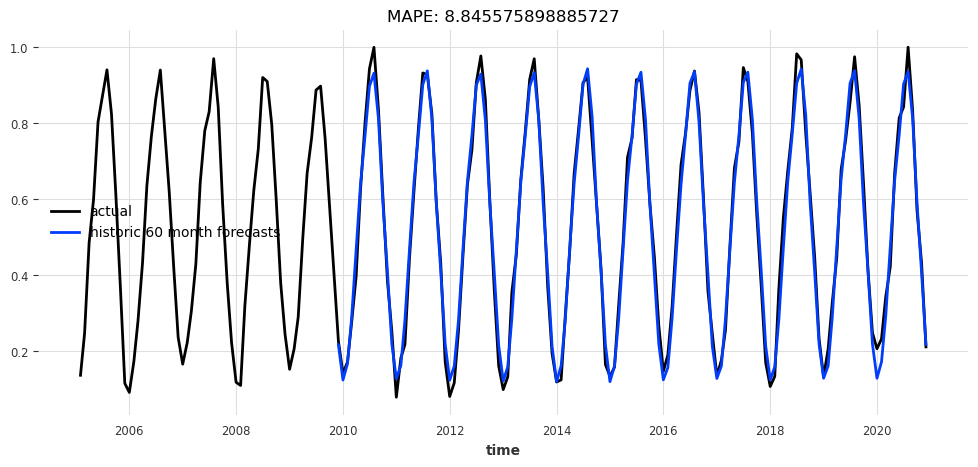

In [13]:
display_forecast(
    pred_series,
    series_scaled,
    "60 month",
    start_date=pd.Timestamp('2005-01-01'),
)

In [14]:
pred_series = model_nbeats.predict(12*80)
pred_series = concatenate(pred_series)

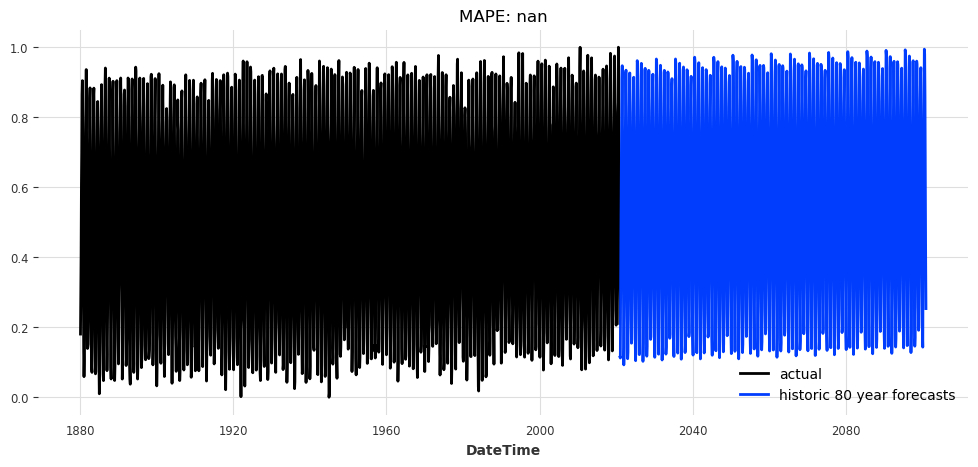

In [15]:
display_forecast(
    pred_series,
    series_scaled,
    "80 year",
    start_date=pd.Timestamp('1880-01-01'),
)

In [16]:
scaler.inverse_transform(series=pred_series).to_csv("a.csv")

In [17]:
forecast = pd.read_csv("a.csv").set_index("DateTime", drop=True)
forecast

,Monthly Anamoly
DateTime,
2021-01-01,1.122450
2021-02-01,1.036247
2021-03-01,7.037697
2021-04-01,11.893024
2021-05-01,16.446625
...,...
2100-08-01,26.582487
2100-09-01,23.094435
2100-10-01,15.329348


In [18]:
rawdata

,Monthly Anamoly
DateTime,
1880-01-01,-0.139
1880-02-01,3.050
1880-03-01,6.034
1880-04-01,9.972
1880-05-01,15.601
...,...
2020-08-01,27.166
2020-09-01,22.270
2020-10-01,14.491


In [19]:
total = pd.concat([rawdata, forecast], axis=0)

In [20]:
total.to_csv("./NBEATS_forecast/NBEATS_forecast_tokyo.csv", index=True, header=True)
total

,Monthly Anamoly
DateTime,
1880-01-01 00:00:00,-0.139000
1880-02-01 00:00:00,3.050000
1880-03-01 00:00:00,6.034000
1880-04-01 00:00:00,9.972000
1880-05-01 00:00:00,15.601000
...,...
2100-08-01,26.582487
2100-09-01,23.094435
2100-10-01,15.329348


In [21]:
month12_ma = total["Monthly Anamoly"].rolling(window=12).mean()
year10_ma = total["Monthly Anamoly"].rolling(window=120).mean()

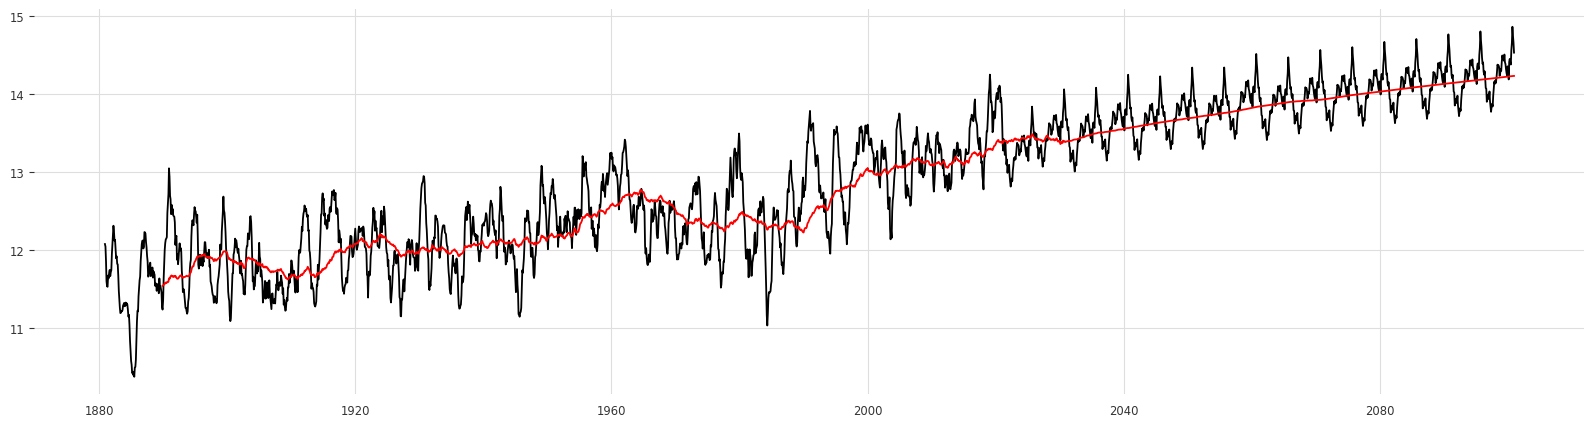

In [22]:
plt.figure(figsize=(20,5))
plt.plot(total.index,month12_ma)
plt.plot(total.index,year10_ma, color='red')